# Homework 3 - 2305
- Tommaso Bertola 2086990
- Giacomo Di Prima 2086992
- Giuseppe Viterbo 2086516
- Marzo Zenari 2097012

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
from sklearn.cluster import DBSCAN

plt.rcParams['font.size'] = 15

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname,fnamey="x_3d.dat","y_3d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  D=",D)
x=data

N= 600   D= 3


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

In [3]:
def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

ll=np.zeros((N, 3))
print(dist(x,13,1))
mdist = np.zeros(N)
for i in range(N):
    length=[]
    dm = 1e100
    for j in range(N):
        if i!=j:
            dij = dist(x,i,j);
            length.append(dij)
            if dij<dm:
                dm = dij
    ll[i] = sorted(length)[:3]
    mdist[i] = dm
mean_min_dist = mdist.mean()
print("mean minimum distance between points: ",mean_min_dist)


569.5269005085432
mean minimum distance between points:  23.321029500210262


# Closest distances distribution

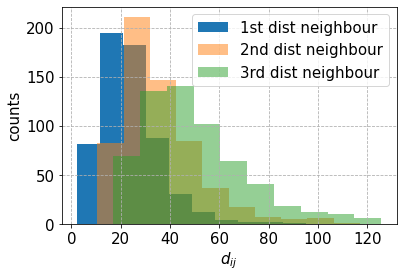

In [4]:
plt.hist(ll[:,0], alpha=1, label='1st dist neighbour')
plt.hist(ll[:,1], alpha=0.5, label='2nd dist neighbour')
plt.hist(ll[:,2], alpha=0.5, label='3rd dist neighbour')
plt.legend()
plt.grid(linestyle='--')
plt.xlabel(r'$d_{ij}$')
plt.ylabel('counts')
plt.show()

## t-SNE visualization, for true labels

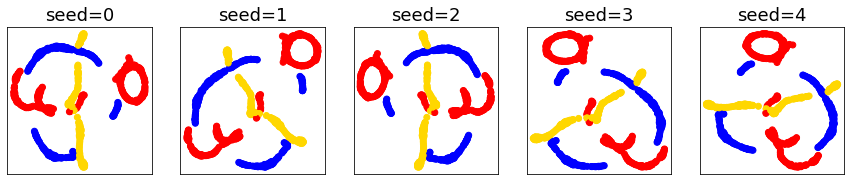

In [5]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexity = 40
Np = 5
mycmap = ListedColormap(["blue","red","gold" ])
X_all=[]
(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

for i in range(5):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=i, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("seed=%d" % i)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)

Varying the random state alters the final rotation and simmetry of the projected data. We can go from the first to the second plot by rotation and the same goes from the third up to the fifth one. The second and the third plots differ from each other by axial simmetry.

## DBSCAN: find labels by applying clustering

In [6]:
# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
from sklearn.cluster import DBSCAN
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
ms = 6

import seaborn as sns
np.random.seed(12345)

#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[0] # best visualization above
X = data
y_true = y

#eps_range = np.linspace(50, 400, 100)
def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)


if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
    
eps_range = np.linspace(1, 20, 100)*r
minPts=np.arange(60)+1

heat = np.zeros((len(minPts) ,len(eps_range)))

#eps_range = [r,3*r,6*r,9*r,12*r]
#min_sample_range = [3,5,10,20]
#fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,18))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(minPts):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        #plotting_ax(X2D,y_hat,ax[i,j])
        heat[j, i]=NMI(y_hat, y_true)
        #ax[i,j].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,min_samples,nmi))


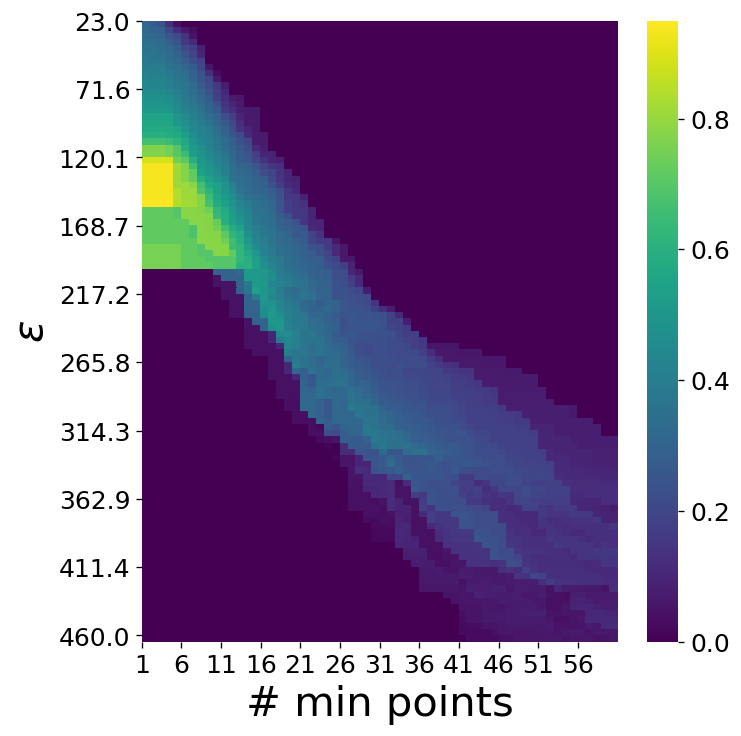

In [7]:
figure, ax = plt.subplots(figsize=(6, 6), dpi=120)
figure.tight_layout()
sns.heatmap(heat.T, ax=ax, yticklabels=10, cmap=sns.color_palette('viridis', as_cmap=True))
ax.set_xlabel('# min points', fontsize=25)
ax.set_ylabel(r'$\epsilon$', fontsize=25)

ax.set_xticks([i*5 for i in range(12)])
ax.set_xticklabels(labels = [i*5+1 for i in range(12)], rotation=0)


ax.set_yticks([i for i in range(0,len(eps_range),11)])
ax.set_yticklabels(labels = [ '{:,.1f}'.format(x) for x in eps_range[::11]],rotation=0)
plt.show()

There is a linear correletion between $\epsilon$ and the minimum number of points. 

This is because increasing the epsilon requires the min number of points to grow so as to keep a meaningful value of NMI.
Increasing $\epsilon$ and keeping the same min number of points would invalidate the cluster finding procedure, as the algorithm would recognize sparse point as clusters. The converse is also true: keeping $\epsilon$ fixed and varying the min number of points.